In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\colin\AppData\Local\Temp\ipykernel_16068\4196587217.py:4: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base.prepare(engine, reflect=True)


In [8]:
# View all of the classes that automap found
available_classes = Base.classes.keys()
print(available_classes)

['measurement', 'station']


In [9]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23


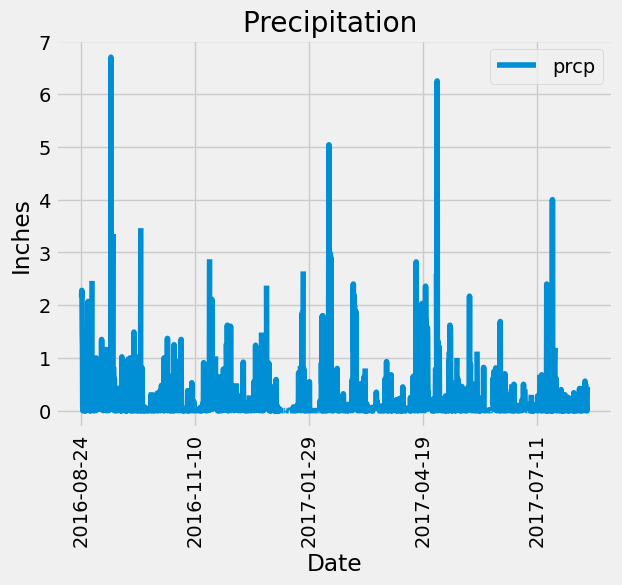

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')


# Calculate the date one year from the last date in data set.
year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year_from_date = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_data_df = pd.DataFrame(last_year_from_date, columns=['date', 'prcp'])


# Sort the dataframe by date
last_year_prcp_df = last_year_data_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
last_year_prcp_df.plot(x='date', y='prcp', rot=90)
plt.title("Precipitation ")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_prcp_df.rename(columns={'prcp': 'Precipitation'}, inplace=True)
summary_statistics = last_year_prcp_df.describe()
print(summary_statistics)

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
Station = Base.classes.station

session = Session(engine)

stations_total = session.query(func.count(Station.station)).all()
print("", stations_total)

 [(9,)]


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station,
    func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print("", most_active_stations)

 [('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

temperature_df = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).one()

print(temperature_df)



(54.0, 85.0, 71.66378066378067)


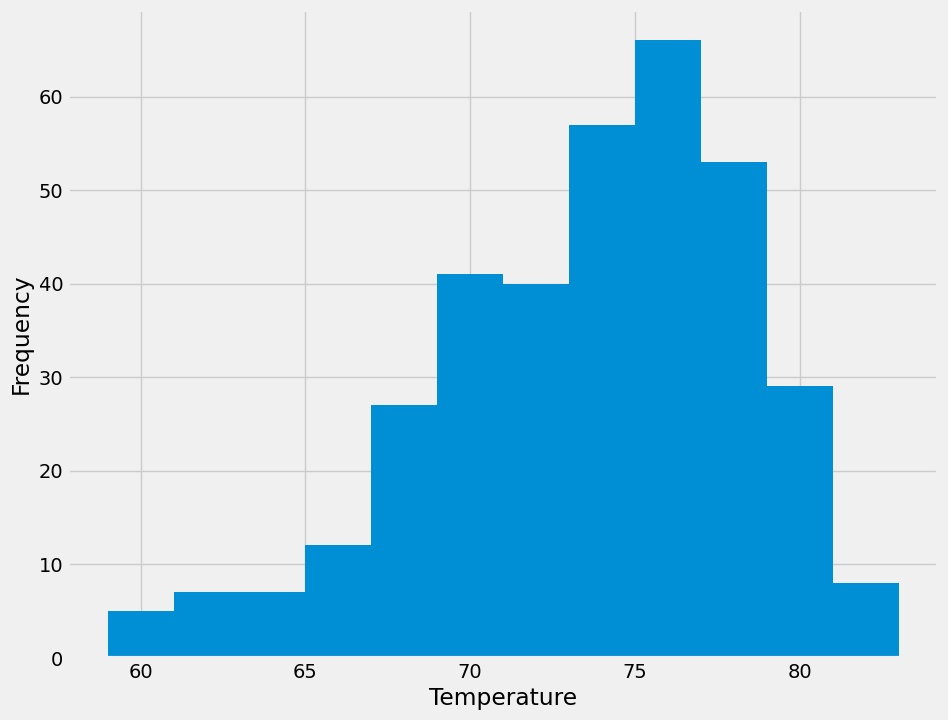

In [21]:
# Using the most active station id
most_active_station_id = most_active_stations[0][0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_df = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= year_ago.strftime('%Y-%m-%d')).all()
temperatures = [temp[0] for temp in temperature_df]
plt.figure(figsize=(10, 8))
plt.hist(temperatures, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [22]:
# Close Session
session.close()